In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10/1.2, 8/1.2]
df = pandas.read_csv("train.csv")
df.drop("customer_id", inplace=True, axis=1)
df = df.dropna()

In [2]:
colums_to_normalize = ['customer_visit_score', 'customer_product_search_score', 'customer_ctr_score', 'customer_stay_score', 'customer_frequency_score', 'customer_product_variation_score', 'customer_order_score', 'customer_affinity_score']
df[colums_to_normalize] = df[colums_to_normalize].apply(lambda x: (x-x.min())/(x.max()-x.min()))

In [3]:
categorical_cols = df.columns[8:11]
le = LabelEncoder()
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [4]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_ro = df[filtered_entries]

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

x = df_ro[['customer_ctr_score','customer_stay_score','customer_visit_score']]
y = df_ro['customer_category']

x_train, x_test, y_train, y_test = train_test_split(x, y)
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_predicted = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_predicted))
print("Precision:", precision_score(y_test, y_predicted))
print("Recall:", recall_score(y_test, y_predicted))


Accuracy: 0.9690812720848057
Precision: 0.8936170212765957
Recall: 0.6961325966850829


In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

[0.96909492 0.97019868 0.96357616 0.97461369 0.97350993 0.97792494
 0.9801105  0.97569061 0.96906077 0.96353591]
Cross validation accuracy: 0.97
AUC: 0.93


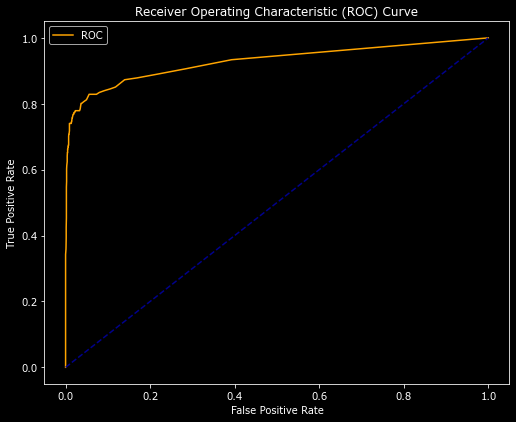

In [7]:
probs = model.predict_proba(x_test)
probs = probs[:, 1]
cva = cross_val_score(model, x, y, cv=10, scoring="accuracy").mean()
print(cross_val_score(model, x, y, cv=10, scoring="accuracy"))
print('Cross validation accuracy: %.2f' % cva)
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

Cross validation accuracy: 0.97
AUC: 0.94


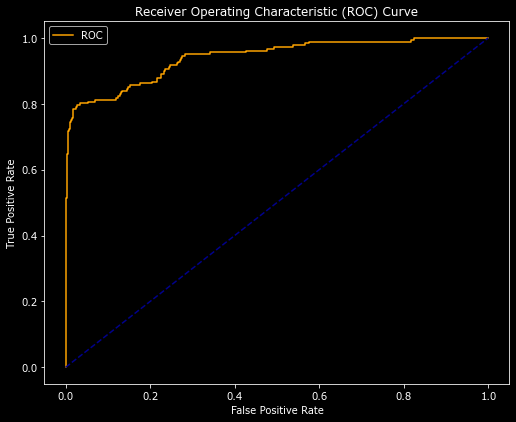

In [8]:
#Support Vector Classification
from sklearn.svm import SVC
model_svc = SVC(kernel='linear',probability = True)
model_svc.fit(x, y)
probs = model_svc.predict_proba(x_test)
probs = probs[:, 1]
cva = cross_val_score(model_svc, x, y, cv=10, scoring="accuracy").mean()
print('Cross validation accuracy: %.2f' % cva)
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [16]:
from sklearn.model_selection import RandomizedSearchCV

x = df_ro[df_ro.columns[:-1]]
y = df_ro['customer_category']
x_train, x_test, y_train, y_test = train_test_split(x, y)

params = {'max_depth': [3, 5, 10, 15, None],
          'n_estimators': [10, 100, 200, 300, 400, 500],
          'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9],
          'min_samples_split': [2, 3, 4],
          'min_samples_leaf': [1, 2, 3, 4],
              }
rnd_search = RandomizedSearchCV(RandomForestClassifier(), params)
rnd_search.fit(x,y)
rnd_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 7,
 'max_depth': None}

In [17]:
par_model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=2, max_features=7, max_depth=None)
par_model.fit(x_train, y_train)
par_y_predicted = par_model.predict(x_test)

print("Usual Random forest: ", accuracy_score(y_test, y_predicted))
print("Random forest with better parametrs: ", accuracy_score(y_test, par_y_predicted))

Usual Random forest:  0.8683745583038869
Random forest with better parametrs:  0.9783568904593639
